In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
include("../src/worker_fct.jl")
data_type = "cal"
dataset = "v07.01"
high_cut = 4
set = "data";

In [2]:
base_path  = "../../waveforms/calib/v07.01/"
base_path_AE  = "../../waveforms/data/calib_AE/"

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)
sf_lib_filepath = "../dicts/sf_lib.json"
sf_lib = JSON.parsefile(sf_lib_filepath)
det_lib_filepath = "../dicts/det_lib.json"
det_lib = JSON.parsefile(det_lib_filepath)

Dict{String, Any} with 30 entries:
  "GD02B" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD76B" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD02A" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD35C" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD61B" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD61C" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD89B" => Dict{String, Any}("str"=>"0065-0079", "run_str"=>"run0065-0079", "…
  "GD32C" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD91B" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD02D" => Dict{String, Any}("str"=>"0065-0079", "run_str"=>"run0065-0079", "…
  "GD35A" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-0092", "…
  "GD61A" => Dict{String, Any}("str"=>"0080-0092", "run_str"=>"run0080-009

# DEP 90% acceptance cut SF (calib data)

In [ ]:
fails = []
success_plots = []
for ch in 0:1:36
    if !ctb[ch] || ch in [5,6,7]
        continue
    end
    ch_str = lpad(ch, 2, "0");
    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"

    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    data = data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table;

    E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    A = deepcopy(data.A)

    pl = 1592.5
    sf_lib = JSON.parsefile(sf_lib_filepath)
    sf_lib[ctn[ch]][set][string(pl)] = Dict()
    cut_lib = JSON.parsefile(cut_lib_filepath)

    parNoCut_dict = cut_lib[ctn[ch]][set]["DEP_ref"][1]
    sf_lib[ctn[ch]][set][string(pl)]["fitNoCut"] = cut_lib[ctn[ch]][set]["DEP_ref"]
    parNoCut = (
        n = parNoCut_dict["n"],
        σ = parNoCut_dict["σ"],
        μ = parNoCut_dict["μ"],
        bkg_l = parNoCut_dict["bkg_l"],
        bkg_r = parNoCut_dict["bkg_r"],
        c = parNoCut_dict["c"],
        d = parNoCut_dict["d"],
        β = parNoCut_dict["β"]
    )


    AoE = A ./ E
    AoE ./= calib[ctn[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
    AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

    rng_step  = cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"]
    rng_width = 15
    rng = 1592.5-rng_width:rng_step:1592.5+rng_width



    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]

    index = eachindex(AoE)
    h = fit(Histogram, E[index], rng)

    indexCut =  findall(x-> cut < x < high_cut, AoE)
    hCut = fit(Histogram, E[indexCut], rng)

    indexCut_min =  findall(x-> cut + cut_err < x < high_cut, AoE)
    hCut_min = fit(Histogram, E[indexCut_min], rng)

    indexCut_max =  findall(x-> cut - cut_err < x < high_cut, AoE)
    hCut_max = fit(Histogram, E[indexCut_max], rng)

    ##
    #
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut

    parGauss = (n = parNoCut.n, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = 0, bkg_r = 0, c = 0, d = 0, β = parNoCut.β)
    y_gauss = peak(x_fit, parGauss) .* calNoCut

    parTail   = (n = 0, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = 0, bkg_r = 0, c = parNoCut.c, d = parNoCut.d, β = parNoCut.β)
    y_tail = peak(x_fit, parTail) .* calNoCut

    parBkg    = (n = 0, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = parNoCut.bkg_l, bkg_r = parNoCut.bkg_r, c = 0, d = 0, β = parNoCut.β)
    y_bkg = peak(x_fit, parBkg) .* calNoCut
    #
    ##
    p = plot(h, st=:step, label="All events")
    p = plot!(x_fit, y_fit, label="Fit all events", lw=2, color=:black)
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, legend=:topleft)
    p = plot!(x_fit, y_gauss, label="Gauss", color=:black, style=:dash)
    p = plot!(x_fit, y_tail, label="Tail", color=:black, style=:dashdot)
    p = plot!(x_fit, y_bkg, label="Background", color=:black)
    p = plot!(xlim=(rng[1], rng[end]))
    
    #
    ## Calculate Cut fit
    #
    
    cuts = cut_lib[ctn[ch]][set]["fitting"]["cuts"]
    best_cut = [minimum(cuts), abs(abs(minimum(cuts)) - abs(cut))]
    for c in cuts
        if abs(abs(c) - abs(cut)) < best_cut[2]
            best_cut[1] = c
            best_cut[2] = abs(abs(c) - abs(cut))
        end
    end
    # best_cut[1] -= -0.#2
    best_cut[1] = round(best_cut[1], digits=1)
    println("Cut value at " * string(cut))
    println("Closest cut value at " * string(best_cut[1]))

    p0_dict = cut_lib[ctn[ch]][set]["fitting"]["fits"][string(best_cut[1])][1]
    p0 = (
        n = p0_dict["n"],
        σ = p0_dict["σ"],
        μ = p0_dict["μ"],
        bkg_l = p0_dict["bkg_l"],
        bkg_r = p0_dict["bkg_r"],
        c = p0_dict["c"],
        d = p0_dict["d"],
        β = p0_dict["β"]
    )
    var = 1.15

    prior = NamedTupleDist(
        n = p0.n/var..p0.n*var,
        σ = p0.σ/var..p0.σ*var,
        μ = p0.µ - 0.5..p0.µ + 0.5,
        bkg_l = p0.bkg_l/1.5..p0.bkg_l*var,
        bkg_r = p0.bkg_r/1.5..p0.bkg_r*var,
        c = p0.c/var..p0.c*var,
        d = p0.d/var..p0.d*var,
        β = p0.β/(2*var)..p0.β*var
    )
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut
    p = plot(h, st=:step, label="Data high cut")
    p = plot!(x_fit, y_fit, label="Fit high cut", lw=2, color=:black)
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, legend=:topleft)

    @info("Normal Cut")
    fail = false
    samplesCut = try bat_fit(hCut, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        try bat_fit(hCut, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                push!(fails, ch)
                continue
            end
        end
    end
    IJulia.clear_output(true)
    parCut, errCut = mode(samplesCut), std(samplesCut)
    x_fit = float.(midpoints(hCut.edges[1]))
    y_fit = peak(x_fit, parCut)
    calCut = sum(hCut.weights)/sum(y_fit)
    y_fit .*= calCut

    k = (parCut[1] + parCut[6])# * calCut
    N = (parNoCut[1] + parNoCut[6]) #* calNoCut
    sf = k/N
    sf_err = (1/N) * sqrt(abs(k*(1-k/N)))

    p = plot!(hCut, st=:step, label="Data low cut: " * string(round(cut, digits=2)))
    p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=3)) * " %")
    p = plot!(xlabel="Energy [keV]", ylabel="Samples")
    display(p)
    
    #
    ## Calculate Min/Max fits
    #
    
    # Minimum
    @info("Minimum")
    samples_min = try bat_fit(hCut_min, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        try bat_fit(hCut_min, peak, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut_min, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                push!(fails, ch)
                continue
            end
        end
    end
    IJulia.clear_output(true)
    parCut_min, errCut_min = mode(samples_min), std(samples_min)
    x_fit = float.(midpoints(hCut_min.edges[1]))
    y_fit = peak(x_fit, parCut_min)
    calCut_min = sum(hCut_min.weights)/sum(y_fit)
    y_fit .*= calCut_min

    k_min = (parCut_min[1] + parCut_min[6]) #* calCut_min
    N = (parNoCut[1] + parNoCut[6]) #* calNoCut
    sf_min = k_min/N
    sf_err_min = (1/N) * sqrt(abs(k_min*(1-k_min/N)))

    p = plot!(x_fit, y_fit, label="Min.: " * string(round(sf_min*100, digits=3)) * " %")
    display(p)

    # Maximum
    @info("Maximum")
    samples_max = try bat_fit(hCut_max, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        try bat_fit(hCut_max, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut_max, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                push!(fails, ch)
                continue
            end
        end
    end
    IJulia.clear_output(true)
    parCut_max, errCut_max = mode(samples_max), std(samples_max)
    x_fit = float.(midpoints(hCut_max.edges[1]))
    y_fit = peak(x_fit, parCut_max)
    calCut_max = sum(hCut_max.weights)/sum(y_fit)
    y_fit .*= calCut_max

    k_max = (parCut_max[1] + parCut_max[6]) #* calCut_max
    N = (parNoCut[1] + parNoCut[6]) #* calNoCut
    sf_max = k_max/N
    sf_err_max = (1/N) * sqrt(abs(k_max*(1-k_max/N)))

    p = plot!(x_fit, y_fit, label="Max.: " * string(round(sf_max*100, digits=3)) * " %")
    p = plot!(framestyle=:box)
    display(p)
    filename = joinpath(plots_path, "DEP_cut_90.pdf")
    savefig(p, filename);


    sf_lib[ctn[ch]][set][string(pl)]["fitCut"] = [parCut, errCut]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_min"] = [parCut_min, errCut_min]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_max"] = [parCut_max, errCut_max]

    sf_lib[ctn[ch]][set][string(pl)]["sf"] = [sf, sf_err]
    sf_lib[ctn[ch]][set][string(pl)]["sf_min"] = [sf_min, sf_err_min]
    sf_lib[ctn[ch]][set][string(pl)]["sf_max"] = [sf_max, sf_err_max]

    sf = measurement(sf_lib[ctn[ch]][set][string(pl)]["sf"][1], sf_lib[ctn[ch]][set][string(pl)]["sf"][2])
    sf_min = measurement(sf_lib[ctn[ch]][set][string(pl)]["sf_min"][1], sf_lib[ctn[ch]][set][string(pl)]["sf_min"][2])
    sf_max = measurement(sf_lib[ctn[ch]][set][string(pl)]["sf_max"][1], sf_lib[ctn[ch]][set][string(pl)]["sf_max"][2])
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["sf"] = sf.val
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_stat"] = sf.err
    err_sys_max = abs(sf.val - sf_max.val)
    err_sys_min = abs(sf.val - sf_min.val)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_min"] = err_sys_min
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_max"] = err_sys_max
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_up"] = sqrt(sf.err^2 + err_sys_max^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_down"] = sqrt(sf.err^2 + err_sys_min^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err"] = maximum([sqrt(sf.err^2 + err_sys_max^2), sqrt(sf.err^2 + err_sys_min^2)])

    open(sf_lib_filepath, "w") do f
        JSON.print(f, sf_lib, 4)
    end
    p = plot!(title="Ch" * ch_str)
    push!(success_plots, p)
end
@bell sleep(1)
fails

# DEP 90% acceptance cut SF (calib data) only high cut

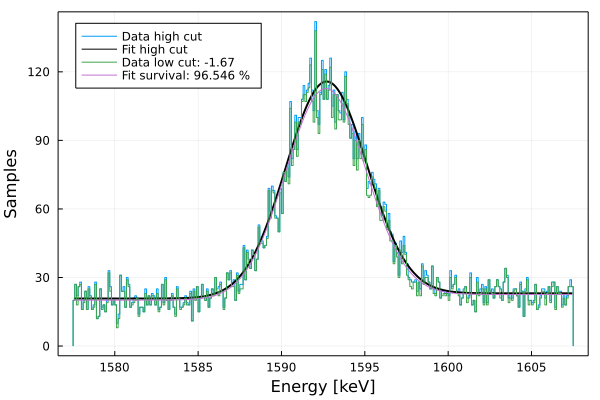

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

Any[]

In [17]:
fails = []
success_plots = []
for ch in 0:1:36
    if !ctb[ch] || ch in [5,6,7]
        continue
    end
    ch_str = lpad(ch, 2, "0");
    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"

    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    data = data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table;

    E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    A = deepcopy(data.A)

    pl = 1592.5
    
    cut_lib = JSON.parsefile(cut_lib_filepath)
    sf_lib = JSON.parsefile(sf_lib_filepath)
    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"] = Dict()

    parNoCut_dict = cut_lib[ctn[ch]][set]["DEP_ref"][1]
    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["fitNoCut"] = cut_lib[ctn[ch]][set]["DEP_ref"]
    parNoCut = (
        n = parNoCut_dict["n"],
        σ = parNoCut_dict["σ"],
        μ = parNoCut_dict["μ"],
        bkg_l = parNoCut_dict["bkg_l"],
        bkg_r = parNoCut_dict["bkg_r"],
        c = parNoCut_dict["c"],
        d = parNoCut_dict["d"],
        β = parNoCut_dict["β"]
    )


    AoE = A ./ E
    AoE ./= calib[ctn[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
    AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

    rng_step  = cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"]
    rng_width = 15
    rng = 1592.5-rng_width:rng_step:1592.5+rng_width



    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]

    h = fit(Histogram, E, rng)

    indexCut =  findall(x-> x < high_cut, AoE)
    hCut = fit(Histogram, E[indexCut], rng)

    ##
    #
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut

    parGauss = (n = parNoCut.n, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = 0, bkg_r = 0, c = 0, d = 0, β = parNoCut.β)
    y_gauss = peak(x_fit, parGauss) .* calNoCut

    parTail   = (n = 0, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = 0, bkg_r = 0, c = parNoCut.c, d = parNoCut.d, β = parNoCut.β)
    y_tail = peak(x_fit, parTail) .* calNoCut

    parBkg    = (n = 0, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = parNoCut.bkg_l, bkg_r = parNoCut.bkg_r, c = 0, d = 0, β = parNoCut.β)
    y_bkg = peak(x_fit, parBkg) .* calNoCut
    #
    ##
    p = plot(h, st=:step, label="All events")
    p = plot!(x_fit, y_fit, label="Fit all events", lw=2, color=:black)
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, legend=:topleft)
    p = plot!(x_fit, y_gauss, label="Gauss", color=:black, style=:dash)
    p = plot!(x_fit, y_tail, label="Tail", color=:black, style=:dashdot)
    p = plot!(x_fit, y_bkg, label="Background", color=:black)
    p = plot!(xlim=(rng[1], rng[end]))
    
    #
    ## Calculate Cut fit
    #

    p0 = deepcopy(parNoCut)
    var = 1.15

    prior = NamedTupleDist(
        n = p0.n/var..p0.n*var,
        σ = p0.σ/var..p0.σ*var,
        μ = p0.µ - 0.5..p0.µ + 0.5,
        bkg_l = p0.bkg_l/1.5..p0.bkg_l*var,
        bkg_r = p0.bkg_r/1.5..p0.bkg_r*var,
        c = p0.c/var..p0.c*var,
        d = p0.d/var..p0.d*var,
        β = p0.β/(2*var)..p0.β*var
    )
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut
    p = plot(h, st=:step, label="Data high cut")
    p = plot!(x_fit, y_fit, label="Fit high cut", lw=2, color=:black)
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, legend=:topleft)

    @info("Normal Cut")
    fail = false
    samplesCut = try bat_fit(hCut, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        try bat_fit(hCut, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                push!(fails, ch)
                continue
            end
        end
    end
    IJulia.clear_output(true)
    parCut, errCut = mode(samplesCut), std(samplesCut)
    x_fit = float.(midpoints(hCut.edges[1]))
    y_fit = peak(x_fit, parCut)
    calCut = sum(hCut.weights)/sum(y_fit)
    y_fit .*= calCut

    k = (parCut[1] + parCut[6])# * calCut
    N = (parNoCut[1] + parNoCut[6]) #* calNoCut
    sf = k/N
    sf_err = (1/N) * sqrt(abs(k*(1-k/N)))

    p = plot!(hCut, st=:step, label="Data low cut: " * string(round(cut, digits=2)))
    p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=3)) * " %")
    p = plot!(xlabel="Energy [keV]", ylabel="Samples")
    display(p)
    filename = joinpath(plots_path, "DEP_high_cut_only.pdf")
    savefig(p, filename);


    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["fitCut"] = [parCut, errCut]
    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["sf"] = [sf, sf_err]

    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["sf_result"]["sf"] = sf
    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["sf_result"]["err_stat"] = sf_err
    sf_lib[ctn[ch]][set][string(pl)*"-high-cut"]["sf_result"]["err"] = sf_err

    open(sf_lib_filepath, "w") do f
        JSON.print(f, sf_lib, 4)
    end
    p = plot!(title="Ch" * ch_str)
    push!(success_plots, p)
end
@bell sleep(1)
fails

In [ ]:
for p in success_plots
    IJulia.clear_output(true)
    display(p)
    sleep(1)
end

# Survival Fractions for other peaks

### FEP (Bi)

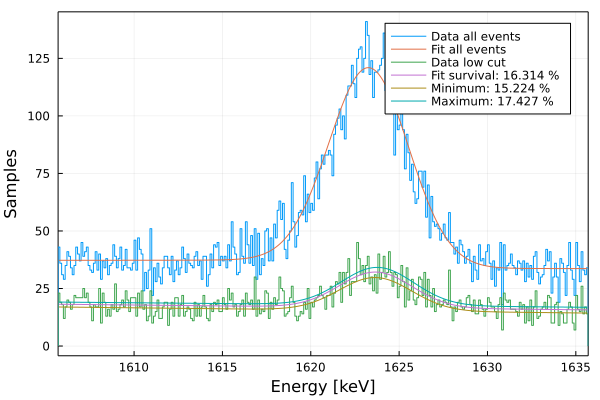

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

┌ Info: Ch26
└ @ Main In[9]:213


Any[]

In [9]:
fails = []
success_plots = []
for ch in [26]#0:1:36
    if !ctb[ch] || ch in [5,6,7]
        continue
    end
    ch_str = lpad(ch, 2, "0");
    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"

    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    data = data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table;

    E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    A = deepcopy(data.A)
    photon_lines = [1620.7, 2103.5, 2614.5]; # keV
    sf_lib = JSON.parsefile(sf_lib_filepath)
    cut_lib = JSON.parsefile(cut_lib_filepath)

    AoE = A ./ E
    AoE ./= calib[ctn[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
    AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

    rng_step  = cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"]
    rng_width = 15
    pl = photon_lines[1]
    rng = pl-rng_width:rng_step:pl+rng_width

    sf_lib[ctn[ch]][set][string(pl)] = Dict()

    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]

    prior = NamedTupleDist(
        n = 100.0..10000.0,
        σ = 0.5..3.0,
        μ = pl - 1..pl + 3,
        bkg_l = 1.0..500.0,
        bkg_r = 1.0..500.0,
        c = 1.0..50,
        d = 0.01..100.0,
        β = 0.1..20.0
    )

    #--------------------------------------------------
    index = eachindex(AoE)#findall(x-> x < high_cut, AoE)
    h = fit(Histogram, E[index], rng)

    indexCut = findall(x-> cut < x < high_cut, AoE)
    hCut = fit(Histogram, E[indexCut], rng)

    indexCut_min =  findall(x-> cut + cut_err < x < high_cut, AoE)
    hCut_min = fit(Histogram, E[indexCut_min], rng)

    indexCut_max =  findall(x-> cut - cut_err < x < high_cut, AoE)
    hCut_max = fit(Histogram, E[indexCut_max], rng)

    p = plot(h, st=:step, label="High Cut", framestyle=:box, xlabel="Energy [keV]", ylabel="Samples")
    p = plot!(hCut, st=:step, label="Low Cut")
    p = plot!(hCut_min, st=:step, label="Minimum")
    p = plot!(hCut_max, st=:step, label="Maximum")
    display(p)


    fail = false
    samples = try bat_fit(h, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
    catch
        IJulia.clear_output(true)
        try bat_fit(h, peak, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            try bat_fit(h, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
            catch
                fail = true
            end
        end
    end
    IJulia.clear_output(true)
    if fail
        push!(fails, ch)
        continue
    end
    parNoCut, errNoCut = mode(samples), std(samples)
    ##
    #
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut
    #
    ##

    p = plot(h, st=:step, label="Data all events")
    p = plot!(x_fit, y_fit, label="Fit all events")
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, xlim=(rng[1], rng[end]))
    @info("Ch" * ch_str)
    display(p)

    p0 = deepcopy(parNoCut)
    factor = sum(hCut.weights)/sum(h.weights)
    var = 1.1
    priorCut = NamedTupleDist(
        n = p0.n/10 * factor..p0.n*var * factor,
        σ = p0.σ/var..p0.σ*var,
        μ = p0.µ - 0.5..p0.µ + 1,
        bkg_l = p0.bkg_l/20..p0.bkg_l*var,
        bkg_r = p0.bkg_r/20..p0.bkg_r*var,
        c = p0.c/10 * factor..p0.c*var * factor,
        d = 0.005..100.0,
        β = 0.1..20.0
    )

    @info("Normal Fit")
    fail = false
    samplesCut = try bat_fit(hCut, peak, priorCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false);
    catch
        try bat_fit(hCut, peak, priorCut; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            fail = true
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
        
    parCut, errCut = mode(samplesCut), std(samplesCut)
    IJulia.clear_output(true)

    x_fit = float.(midpoints(hCut.edges[1]))
    y_fit = peak(x_fit, parCut)
    calCut = sum(hCut.weights)/sum(y_fit)
    y_fit .*= calCut

    k = (parCut[1] + parCut[6]) * calCut
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf = k/N
    sf_err = (1/N) * sqrt(abs(k*(1-k/N)))

    p = plot!(hCut, st=:step, label="Data low cut")
    p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=3)) * " %")
    @info("Ch" * ch_str)
    display(p)
    
    #
    ## Calc Min/Max fits
    #
    
    # Minimum
    @info("Minimum Fit")
    fail = false
    samples_min = try bat_fit(hCut_min, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut_min, peak, priorCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
        catch 
            fail = true
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut_min, errCut_min = mode(samples_min), std(samples_min)
    IJulia.clear_output(true)

    x_fit = float.(midpoints(hCut_min.edges[1]))
    y_fit = peak(x_fit, parCut_min)
    calCut_min = sum(hCut_min.weights)/sum(y_fit)
    y_fit .*= calCut_min

    k_min = (parCut_min[1] + parCut_min[6]) * calCut_min
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf_min = k_min/N
    sf_err_min = (1/N) * sqrt(abs(k_min*(1-k_min/N)))

    p = plot!(x_fit, y_fit, label="Minimum: " * string(round(sf_min*100, digits=3)) * " %")
    @info("Ch" * ch_str)
    display(p)

    # Maximum
    @info("Maximum Fit")
    fail = false
    samples_max = try bat_fit(hCut_max, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut_max, peak, priorCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
        catch 
            fail = true
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut_max, errCut_max = mode(samples_max), std(samples_max)
    IJulia.clear_output(true)

    x_fit = float.(midpoints(hCut_max.edges[1]))
    y_fit = peak(x_fit, parCut_max)
    calCut_max = sum(hCut_max.weights)/sum(y_fit)
    y_fit .*= calCut_max

    k_max = (parCut_max[1] + parCut_max[6]) * calCut_max
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf_max = k_max/N
    sf_err_max = (1/N) * sqrt(abs(k_max*(1-k_max/N)))

    p = plot!(x_fit, y_fit, label="Maximum: " * string(round(sf_max*100, digits=3)) * " %")
    @info("Ch" * ch_str)
    display(p)

    filename = joinpath(plots_path, "sf/FEP_Bi.pdf")
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    savefig(p, filename);
    #
    ##
    sf_lib[ctn[ch]][set][string(pl)]["fitCut"] = [parCut, errCut]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_min"] = [parCut_min, errCut_min]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_max"] = [parCut_max, errCut_max]
    sf_lib[ctn[ch]][set][string(pl)]["fitNoCut"] = [parNoCut, errNoCut]

    sf_lib[ctn[ch]][set][string(pl)]["sf"] = [sf, sf_err]
    sf_lib[ctn[ch]][set][string(pl)]["sf_min"] = [sf_min, sf_err_min]
    sf_lib[ctn[ch]][set][string(pl)]["sf_max"] = [sf_max, sf_err_max]
    
    err_stat = sf_err
    err_sys_min = abs(sf - sf_min)
    err_sys_max = abs(sf - sf_max)
    
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["sf"] = sf
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_stat"] = sf_err
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_min"] = abs(sf - sf_min)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_max"] = abs(sf - sf_max)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_up"] = sqrt(err_stat^2 + err_sys_max^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_down"] = sqrt(err_stat^2 + err_sys_min^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err"] = maximum([sqrt(err_stat^2 + err_sys_max^2), sqrt(err_stat^2 + err_sys_min^2)])
    
    open(sf_lib_filepath, "w") do f
        JSON.print(f, sf_lib, 4)
    end
    p = plot!(title="ch" * ch_str)
    push!(success_plots, p)
end
@bell sleep(1)
fails

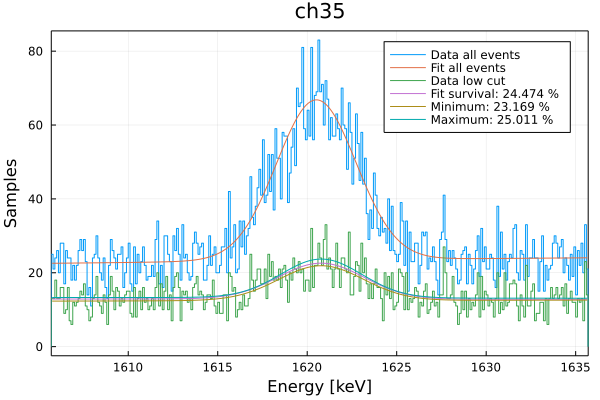

In [4]:
for p in success_plots
    IJulia.clear_output(true)
    display(p)
    sleep(1)
end

### SEP

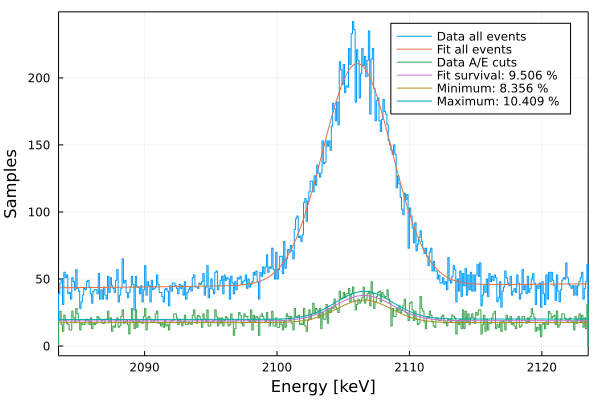

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

Any[]

In [13]:
fails = []
success_plots = []
for ch in [26]#0:1:36
    if !ctb[ch] || ch in [5,6,7]
        continue
    end
    fail = false
    ch_str = lpad(ch, 2, "0");
    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"

    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    data = data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table;

    E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    A = deepcopy(data.A)
    photon_lines = [1620.7, 2103.5, 2614.5]; # keV
    sf_lib = JSON.parsefile(sf_lib_filepath)
    cut_lib = JSON.parsefile(cut_lib_filepath)

    AoE = A ./ E
    AoE ./= calib[ctn[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
    AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

    rng_step  = cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"]
    rng_width = 20#15
    pl = photon_lines[2]
    rng = pl-rng_width:rng_step:pl+rng_width


    sf_lib[ctn[ch]][set][string(pl)] = Dict()

    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]

    index = eachindex(AoE)#findall(x-> x < high_cut, AoE)
    h = fit(Histogram, E[index], rng)

    indexCut = findall(x-> cut < x < high_cut, AoE)
    hCut = fit(Histogram, E[indexCut], rng)

    indexCut_min =  findall(x-> cut + cut_err < x < high_cut, AoE)
    hCut_min = fit(Histogram, E[indexCut_min], rng)

    indexCut_max =  findall(x-> cut - cut_err < x < high_cut, AoE)
    hCut_max = fit(Histogram, E[indexCut_max], rng)

    p = plot(h, st=:step, label="All events", framestyle=:box, xlabel="Energy [keV]", ylabel="Samples")
    p = plot!(hCut, st=:step, label="A/E cuts")
    p = plot!(hCut_min, st=:step, label="Minimum")
    p = plot!(hCut_max, st=:step, label="Maximum")
    display(p)

    prior = NamedTupleDist(
        n = 100.0..2e4,
        σ = 0.5..3.0,
        μ = pl - 3..pl + 3,
        bkg_l = 1.0..500.0,
        bkg_r = 1.0..500.0,
        c = 1.0..150,
        d = 0.01..100.0,
        β = 0.1..20.0
    )
    @info("No Cut")
    samples = try bat_fit(h, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
    catch 
        IJulia.clear_output(true)
        try bat_fit(h, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            try bat_fit(h, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
            catch
                fail = true
            end
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    IJulia.clear_output(true)
    parNoCut, errNoCut = mode(samples), std(samples)
    ##
    #
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut
    #
    ##

    p = plot(h, st=:step, label="Data all events")
    p = plot!(x_fit, y_fit, label="Fit all events")
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, xlim=(rng[1], rng[end]))
    display(p)


    p0 = deepcopy(parNoCut)
    factor = sum(hCut.weights)/sum(h.weights)
    var = 1.1
    priorCut = NamedTupleDist(
        n = p0.n/10 * factor..p0.n*var * factor,
        σ = p0.σ/var-0.5..p0.σ*var,
        μ = p0.µ - 0.5..p0.µ + 0.5,
        bkg_l = p0.bkg_l/20..p0.bkg_l*var,
        bkg_r = p0.bkg_r/20..p0.bkg_r*var,
        c = p0.c/10 * factor..p0.c*var * factor,
        d = 0.01..100.0,
        β = 0.15..20.0
    );
    
    
    #
    ## NORMAL CUT FIT
    #
    
    ##
    #
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut
    #
    ##

    p = plot(h, st=:step, label="Data all events")
    p = plot!(x_fit, y_fit, label="Fit all events")
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, xlim=(rng[1], rng[end]))


    @info("Normal Cut Fit")
    samplesCut = try bat_fit(hCut, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
    catch
        IJulia.clear_output(true)
        try bat_fit(hCut, peak, priorCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            try bat_fit(hCut, peak, priorCut; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
            catch
                fail = true
            end
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut, errCut = mode(samplesCut), std(samplesCut)
    IJulia.clear_output(true)

    x_fit = float.(midpoints(hCut.edges[1]))
    y_fit = peak(x_fit, parCut)
    calCut = sum(hCut.weights)/sum(y_fit)
    y_fit .*= calCut

    k = (parCut[1] + parCut[6]) * calCut
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf = k/N
    sf_err = (1/N) * sqrt(abs(k*(1-k/N)))

    p = plot!(hCut, st=:step, label="Data A/E cuts")
    p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=3)) * " %")
    display(p)
    
    # Minimum
    @info("Minimum Fit")
    samples_min = try bat_fit(hCut_min, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut_min, peak, priorCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut_min, peak, priorCut; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                fail = true
            end
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut_min, errCut_min = mode(samples_min), std(samples_min)
    IJulia.clear_output(true)

    x_fit = float.(midpoints(hCut_min.edges[1]))
    y_fit = peak(x_fit, parCut_min)
    calCut_min = sum(hCut_min.weights)/sum(y_fit)
    y_fit .*= calCut_min

    k_min = (parCut_min[1] + parCut_min[6]) * calCut_min
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf_min = k_min/N
    sf_err_min = (1/N) * sqrt(abs(k_min*(1-k_min/N)))

    p = plot!(x_fit, y_fit, label="Minimum: " * string(round(sf_min*100, digits=3)) * " %")
    display(p)

    # Maximum
    @info("Maximum Fit")
    samples_max = try bat_fit(hCut_max, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut_max, peak, priorCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut_max, peak, priorCut; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                fail = true
            end
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut_max, errCut_max = mode(samples_max), std(samples_max)
    IJulia.clear_output(true)

    x_fit = float.(midpoints(hCut_max.edges[1]))
    y_fit = peak(x_fit, parCut_max)
    calCut_max = sum(hCut_max.weights)/sum(y_fit)
    y_fit .*= calCut_max

    k_max = (parCut_max[1] + parCut_max[6]) * calCut_max
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf_max = k_max/N
    sf_err_max = (1/N) * sqrt(abs(k_max*(1-k_max/N)))

    p = plot!(x_fit, y_fit, label="Maximum: " * string(round(sf_max*100, digits=3)) * " %")
    display(p)

    filename = joinpath(plots_path, "sf/SEP.pdf")
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    savefig(p, filename);
    #
    ##
    sf_lib[ctn[ch]][set][string(pl)]["fitCut"] = [parCut, errCut]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_min"] = [parCut_min, errCut_min]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_max"] = [parCut_max, errCut_max]
    sf_lib[ctn[ch]][set][string(pl)]["fitNoCut"] = [parNoCut, errNoCut]

    sf_lib[ctn[ch]][set][string(pl)]["sf"] = [sf, sf_err]
    sf_lib[ctn[ch]][set][string(pl)]["sf_min"] = [sf_min, sf_err_min]
    sf_lib[ctn[ch]][set][string(pl)]["sf_max"] = [sf_max, sf_err_max]

    err_stat = sf_err
    err_sys_min = abs(sf - sf_min)
    err_sys_max = abs(sf - sf_max)

    sf_lib[ctn[ch]][set][string(pl)]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["sf"] = sf
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_stat"] = err_stat
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_min"] = abs(sf - sf_min)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_max"] = abs(sf - sf_max)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_up"] = sqrt(err_stat^2 + err_sys_max^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_down"] = sqrt(err_stat^2 + err_sys_min^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err"] = maximum([sqrt(err_stat^2 + err_sys_max^2), sqrt(err_stat^2 + err_sys_min^2)])

    open(sf_lib_filepath, "w") do f
        JSON.print(f, sf_lib, 4)
    end
    p = plot!(title="ch" * ch_str)
    push!(success_plots, p)
end
@bell sleep(1)
fails

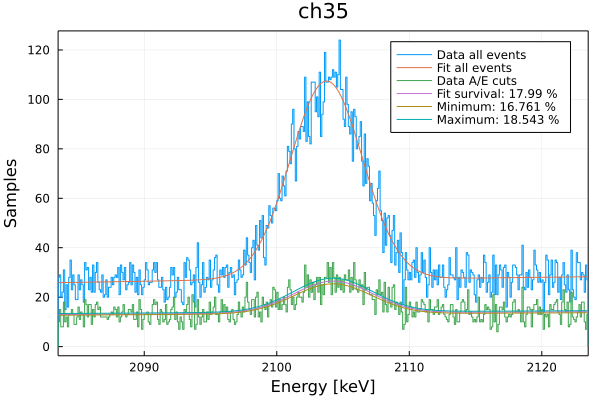

In [11]:
for p in success_plots
    IJulia.clear_output(true)
    display(p)
    sleep(1)
end

### FEP (Tl)

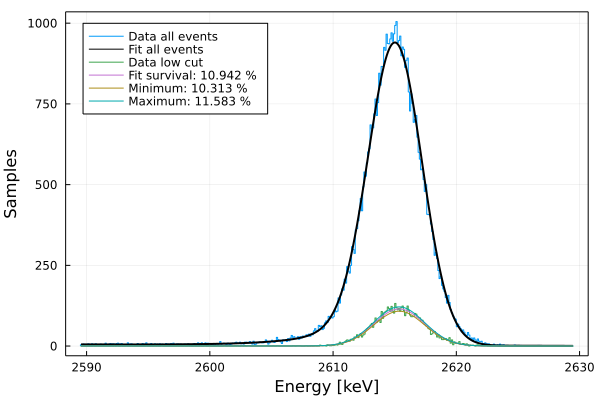

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

(n = 48234.7399058147, σ = 2.173337398486539, μ = 2615.089248434727, bkg_l = 50.36248965672751, bkg_r = 6.241303876797453, c = 5521.352217976668, d = 0.04718542644547978, β = 3.5331612031690027)
---
Uniform{Float64}(a=13640.793985166727, b=272815.87970333453)
Uniform{Float64}(a=1.0865973258459332, b=4.346389303383733)
Uniform{Float64}(a=2613.2830049480217, b=2616.7830049480217)
Uniform{Float64}(a=0.1, b=200.0)
Uniform{Float64}(a=0.1, b=100.0)
Uniform{Float64}(a=372.79082248170147, b=10438.14302948764)
Uniform{Float64}(a=0.01, b=200.0)
Uniform{Float64}(a=0.15, b=20.0)


Any[]

In [21]:
fails = []
success_plots = []
for ch in 0:1:36
    if !ctb[ch] || ch in [5,6,7]
        continue
    end
    fail = false
    ch_str = lpad(ch, 2, "0");
    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"

    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    data = data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table;

    E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    A = deepcopy(data.A)
    photon_lines = [1620.7, 2103.5, 2614.5]; # keV
    sf_lib = JSON.parsefile(sf_lib_filepath);
    cut_lib = JSON.parsefile(cut_lib_filepath);

    pl = photon_lines[3]

    AoE = A ./ E
    AoE ./= calib[ctn[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
    AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"])

    rng_step  = cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"]
    rng_width = 25
    rng = pl-rng_width:rng_step:pl+rng_width#-10

    sf_lib = JSON.parsefile(sf_lib_filepath)
    sf_lib[ctn[ch]][set][string(pl)] = Dict()

    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]

    index = eachindex(AoE)#findall(x-> x < high_cut, AoE)
    h = fit(Histogram, E[index], rng)

    indexCut = findall(x-> cut < x < high_cut, AoE)
    hCut = fit(Histogram, E[indexCut], rng)

    p = plot(h, st=:step)
    p = plot!(hCut, st=:step)
    display(p)


    p0 = calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)][1]

    a = 0.8
    p0 = (
        n = p0["n"]*a,
        σ = p0["σ"]*1.,
        μ = p0["μ"],
        bkg_l = p0["bkg_l"],
        bkg_r = p0["bkg_r"],
        c = p0["c"]*a,
        d = p0["d"],
        β = p0["β"]
    )
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, p0)
    y_fit ./= sum(y_fit)
    y_fit .*= sum(h.weights)
    plot!(x_fit, y_fit)

    rng_step  = cut_lib[ctn[ch]][set]["fitting"]["hist_step_size"]
    rng_width = 25
    rng = pl-rng_width:rng_step:pl+rng_width-10


    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]

    index = eachindex(AoE)
    h = fit(Histogram, E[index], rng)

    indexCut = findall(x-> cut < x < high_cut, AoE)
    hCut = fit(Histogram, E[indexCut], rng)

    indexCut_min =  findall(x-> cut + cut_err < x < high_cut, AoE)
    hCut_min = fit(Histogram, E[indexCut_min], rng)

    indexCut_max =  findall(x-> cut - cut_err < x < high_cut, AoE)
    hCut_max = fit(Histogram, E[indexCut_max], rng)

    p = plot(h, st=:step, label="High Cut", framestyle=:box, xlabel="Energy [keV]", ylabel="Samples")
    p = plot!(hCut, st=:step, label="Low Cut")
    p = plot!(hCut_min, st=:step, label="Minimum")
    p = plot!(hCut_max, st=:step, label="Maximum")
    display(p)
    
    var = 2
    priorNoCut = NamedTupleDist(
    #     n = p0.n/(var)..p0.n*var*10,
        n = p0.n*2..p0.n*var*20,
        σ = p0.σ/(var)..p0.σ*var,
        μ = p0.μ - 1.5..p0.μ + 2,
        bkg_l = 0.1..200,#p0.bkg_l/(2*var)..p0.bkg_l*var,
        bkg_r = 0.1..100,#p0.bkg_r/(2*var)..p0.bkg_r*var,
        c = p0.c/var..p0.c*var*7,
        d = 0.01..200.0,
        β = 0.15..20.0
    )

    samples = try bat_fit(h, peak, priorNoCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
        catch 
        IJulia.clear_output(true)
        try bat_fit(h, peak, priorNoCut; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            IJulia.clear_output(true)
            try bat_fit(h, peak, priorNoCut; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false);
            catch
                fail = true
            end
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parNoCut, errNoCut = mode(samples), std(samples)
    IJulia.clear_output(true)
    ##
    #
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    calNoCut = sum(h.weights)/sum(y_fit)
    y_fit .*= calNoCut

    parGauss = (n = parNoCut.n, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = 0, bkg_r = 0, c = 0, d = 0, β = parNoCut.β)
    y_gauss = peak(x_fit, parGauss) .* calNoCut

    parTail   = (n = 0, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = 0, bkg_r = 0, c = parNoCut.c, d = parNoCut.d, β = parNoCut.β)
    y_tail = peak(x_fit, parTail) .* calNoCut

    parBkg    = (n = 0, σ = parNoCut.σ, μ = parNoCut.μ, bkg_l = parNoCut.bkg_l, bkg_r = parNoCut.bkg_r, c = 0, d = 0, β = parNoCut.β)
    y_bkg = peak(x_fit, parBkg) .* calNoCut
    #
    ##
    p = plot(h, st=:step, label="Data all events")
    p = plot!(x_fit, y_fit, label="Fit all events", lw=2, color=:black)
    p = plot!(x_fit, y_gauss, label="Gauss 1", color=:black, style=:dash)
    p = plot!(x_fit, y_tail, label="Tail", color=:black, style=:dashdot)
    p = plot!(x_fit, y_bkg, label="Background", color=:black)
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, xlim=(rng[1], rng[end]), legend=:topleft)

    p0 = deepcopy(parNoCut)
    factor = sum(hCut.weights)/sum(h.weights)
    var = 1.25
    priorCut = NamedTupleDist(
        n = p0.n/5 * factor..p0.n*var * factor,
        σ = p0.σ/var..p0.σ*var,
        μ = p0.µ - 1.0..p0.µ + 1.0,
        bkg_l = p0.bkg_l/20..p0.bkg_l*var,
        bkg_r = p0.bkg_r/20..p0.bkg_r*var,
        c = p0.c/10 * factor..p0.c*var * factor,
        d = 0.01..200.0,
        β = 0.15..20.0
    )
    p = plot(h, st=:step, label="Data all events")
    p = plot!(x_fit, y_fit, label="Fit all events", lw=2, color=:black)
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box, legend=:topleft)

    @info("Normal Fit")
    samplesCut = try bat_fit(hCut, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut, peak, priorCut; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            fail = true
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut, errCut = mode(samplesCut), std(samplesCut)
    IJulia.clear_output(true)

    y_fit = peak(x_fit, parCut)
    calCut = sum(hCut.weights)/sum(y_fit)
    y_fit .*= calCut

    k = (parCut[1] + parCut[6]) * calCut
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf = k/N
    sf_err = (1/N) * sqrt(abs(k*(1-k/N)))

    p = plot!(hCut, st=:step, label="Data low cut")
    p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=3)) * " %")
    display(p)

    @info("Minimum Fit")
    samplesCut_min = try bat_fit(hCut_min, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut_min, peak, priorCut; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            fail = true
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut_min, errCut_min = mode(samplesCut_min), std(samplesCut_min)
    IJulia.clear_output(true)

    y_fit = peak(x_fit, parCut_min)
    calCut_min = sum(hCut_min.weights)/sum(y_fit)
    y_fit .*= calCut_min

    k_min = (parCut_min[1] + parCut_min[6]) * calCut_min
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf_min = k_min/N
    sf_err_min = (1/N) * sqrt(abs(k_min*(1-k_min/N)))

    p = plot!(x_fit, y_fit, label="Minimum: " * string(round(sf_min*100, digits=3)) * " %")
    display(p)

    @info("Maximum Fit")
    samplesCut_max = try bat_fit(hCut_max, peak, priorCut; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
    catch 
        IJulia.clear_output(true)
        try bat_fit(hCut_max, peak, priorCut; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false);
        catch
            fail = true
        end
    end
    if fail
        push!(fails, ch)
        continue
    end
    parCut_max, errCut_max = mode(samplesCut_max), std(samplesCut_max)
    IJulia.clear_output(true)

    y_fit = peak(x_fit, parCut_max)
    calCut_max = sum(hCut_max.weights)/sum(y_fit)
    y_fit .*= calCut_max

    k_max = (parCut_max[1] + parCut_max[6]) * calCut_max
    N = (parNoCut[1] + parNoCut[6]) * calNoCut
    sf_max = k_max/N
    sf_err_max = (1/N) * sqrt(abs(k_max*(1-k_max/N)))

    p = plot!(x_fit, y_fit, label="Maximum: " * string(round(sf_max*100, digits=3)) * " %")
    display(p)

    filename = joinpath(plots_path, "sf/FEP_Tl.pdf")
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    savefig(p, filename);
    sf_lib = JSON.parsefile(sf_lib_filepath);
    sf_lib[ctn[ch]][set][string(pl)] = Dict()
    sf_lib[ctn[ch]][set][string(pl)]["fitCut"] = [parCut, errCut]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_min"] = [parCut_min, errCut_min]
    sf_lib[ctn[ch]][set][string(pl)]["fitCut_max"] = [parCut_max, errCut_max]
    sf_lib[ctn[ch]][set][string(pl)]["fitNoCut"] = [parNoCut, errNoCut]

    sf_lib[ctn[ch]][set][string(pl)]["sf"] = [sf, sf_err]
    sf_lib[ctn[ch]][set][string(pl)]["sf_min"] = [sf_min, sf_err_min]
    sf_lib[ctn[ch]][set][string(pl)]["sf_max"] = [sf_max, sf_err_max]

    err_stat = sf_err
    err_sys_min = abs(sf - sf_min)
    err_sys_max = abs(sf - sf_max)

    sf_lib[ctn[ch]][set][string(pl)]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["sf"] = sf
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_stat"] = err_stat
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_min"] = abs(sf - sf_min)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_sys_max"] = abs(sf - sf_max)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_up"] = sqrt(err_stat^2 + err_sys_max^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err_down"] = sqrt(err_stat^2 + err_sys_min^2)
    sf_lib[ctn[ch]][set][string(pl)]["sf_result"]["err"] = maximum([sqrt(err_stat^2 + err_sys_max^2), sqrt(err_stat^2 + err_sys_min^2)])
    open(sf_lib_filepath, "w") do f
        JSON.print(f, sf_lib, 4)
    end
    println(parNoCut)
    println("---")
    println(priorNoCut.n)
    println(priorNoCut.σ)
    println(priorNoCut.µ)
    println(priorNoCut.bkg_l)
    println(priorNoCut.bkg_r)
    println(priorNoCut.c)
    println(priorNoCut.d)
    println(priorNoCut.β)
    
    p = plot!(title="ch" * ch_str)
    push!(success_plots, p)
end
@bell sleep(1)
fails

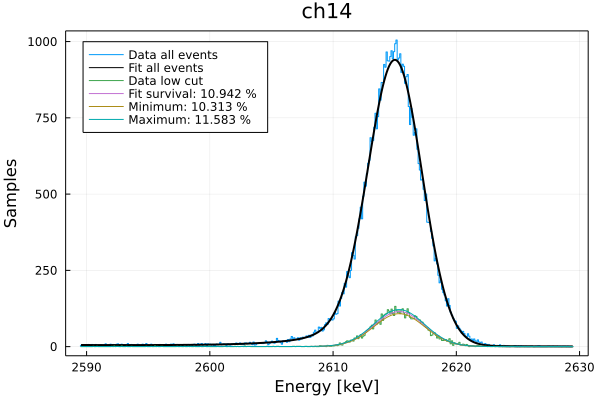

In [22]:
for p in success_plots
    IJulia.clear_output(true)
    display(p)
    sleep(1)
end

In [ ]:
# println(parNoCut)
# println("---")
# priorNoCut = prior
# println(priorNoCut.n)
# println(priorNoCut.σ)
# println(priorNoCut.µ)
# println(priorNoCut.bkg_l)
# println(priorNoCut.bkg_r)
# println(priorNoCut.c)
# println(priorNoCut.d)
# println(priorNoCut.β)
# println(priorNoCut.n2)
# println(priorNoCut.σ2)

# Compton area

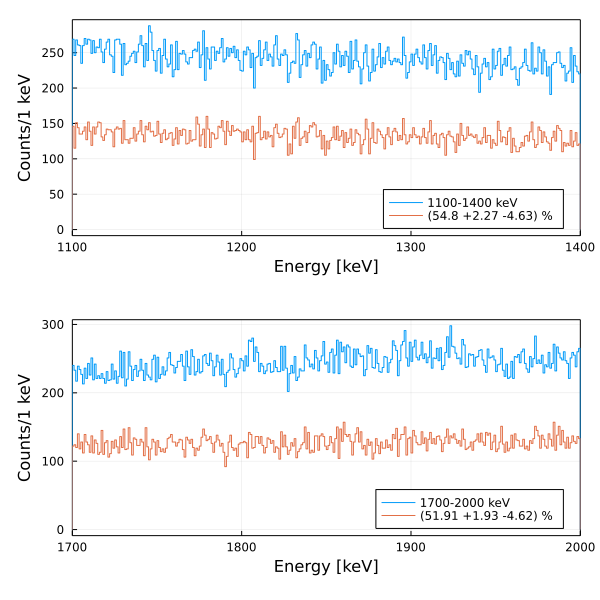

Progress: 100%|█████████████████████████████████████████| Time: 0:03:01


In [23]:
@showprogress for ch in 0:1:36
    if !ctb[ch] || ch in [5,6,7]
        continue
    end
    ch_str = lpad(ch, 2, "0");
    
    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    data = data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table;




    E_rng = (1100,1400);
    sf_lib = JSON.parsefile(sf_lib_filepath)
    E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    A = deepcopy(data.A)

    AoE = A ./ E
    AoE ./= calib[ctn[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
    AoE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"]);

    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]
    cut = measurement(cut, cut_err)

    tt = Table(A = A, E = E, AoE = AoE)
    tt = tt |> @filter(_.E >= E_rng[1] && _.E <= E_rng[2]) |> Table;
    tt_cut = tt |> @filter(_.AoE <= high_cut) |> Table;
    tt_cut = tt |> @filter( _.AoE >= cut.val) |> Table;
    tt_cut_max = tt |> @filter(_.AoE <= high_cut && _.AoE >= cut.val - cut.err) |> Table;
    tt_cut_min = tt |> @filter(_.AoE <= high_cut && _.AoE >= cut.val + cut.err) |> Table;

    k = size(tt_cut,1)
    k_min = size(tt_cut_min,1)
    k_max = size(tt_cut_max,1)
    N = size(tt,1)
    sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
    sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
    sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))
    err_down = sqrt(sf.err^2 + abs(sf.val-sf_min.val)^2)
    err_up = sqrt(sf.err^2 + abs(sf.val-sf_max.val)^2)

    sf_lib[ctn[ch]][set][string(E_rng)] = Dict()
    sf_lib[ctn[ch]][set][string(E_rng)]["sf"] = [sf.val, sf.err]
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_err_down"] = err_down
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_err_up"] = err_up
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_min"] = [sf_min.val, sf_min.err]
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_max"] = [sf_max.val, sf_max.err]
    
    err_stat = sf.err
    err_sys_min = abs(sf.val - sf_min.val)
    err_sys_max = abs(sf.val - sf_max.val)

    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["sf"] = sf.val
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_stat"] = err_stat
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_sys_min"] = err_sys_min
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_sys_max"] = err_sys_max
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_up"] = sqrt(err_stat^2 + err_sys_max^2)
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_down"] = sqrt(err_stat^2 + err_sys_min^2)
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err"] = maximum([sqrt(err_stat^2 + err_sys_max^2), sqrt(err_stat^2 + err_sys_min^2)])
    

    ss = round(sf.val*100, digits=2)
    uu = round(err_up*100, digits=2)
    dd = round(err_down*100, digits=2)

    h = fit(Histogram, tt.E, E_rng[1]:1:E_rng[2])
    hCut = fit(Histogram, tt_cut.E, E_rng[1]:1:E_rng[2])
    hCut_min = fit(Histogram, tt_cut_min.E, E_rng[1]:1:E_rng[2])
    hCut_max = fit(Histogram, tt_cut_max.E, E_rng[1]:1:E_rng[2])
    p1 = plot()
    p1 = plot!(h, st=:step, label=string(E_rng[1], "-", E_rng[2], " keV"), legend=:bottomright)
    p1 = plot!(hCut, st=:step, label=string("(", ss," +",uu," -",dd, ") %"))
    p1 = plot!(xlabel="Energy [keV]", ylabel="Counts/1 keV", xlim=E_rng)
    p1 = plot!(framestyle=:box)
    
    E_rng = (1700,2000);
    tt = Table(A = A, E = E, AoE = AoE)
    tt = tt |> @filter(_.E >= E_rng[1] && _.E <= E_rng[2]) |> Table;
    tt_cut = tt |> @filter(_.AoE <= high_cut) |> Table;
    tt_cut = tt |> @filter(_.AoE >= cut.val) |> Table;
    tt_cut_max = tt |> @filter(_.AoE <= high_cut && _.AoE >= cut.val - cut.err) |> Table;
    tt_cut_min = tt |> @filter(_.AoE <= high_cut && _.AoE >= cut.val + cut.err) |> Table;

    k = size(tt_cut,1)
    k_min = size(tt_cut_min,1)
    k_max = size(tt_cut_max,1)
    N = size(tt,1)
    sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
    sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
    sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))
    err_down = sqrt(sf.err^2 + abs(sf.val-sf_min.val)^2)
    err_up = sqrt(sf.err^2 + abs(sf.val-sf_max.val)^2)
    
    sf_lib[ctn[ch]][set][string(E_rng)] = Dict()
    sf_lib[ctn[ch]][set][string(E_rng)]["sf"] = [sf.val, sf.err]
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_err_down"] = err_down
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_err_up"] = err_up
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_min"] = [sf_min.val, sf_min.err]
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_max"] = [sf_max.val, sf_max.err]
    
    err_stat = sf.err
    err_sys_min = abs(sf.val - sf_min.val)
    err_sys_max = abs(sf.val - sf_max.val)

    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"] = Dict()
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["sf"] = sf.val
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_stat"] = err_stat
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_sys_min"] = err_sys_min
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_sys_max"] = err_sys_max
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_up"] = sqrt(err_stat^2 + err_sys_max^2)
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err_down"] = sqrt(err_stat^2 + err_sys_min^2)
    sf_lib[ctn[ch]][set][string(E_rng)]["sf_result"]["err"] = maximum([sqrt(err_stat^2 + err_sys_max^2), sqrt(err_stat^2 + err_sys_min^2)])

    ss = round(sf.val*100, digits=2)
    uu = round(err_up*100, digits=2)
    dd = round(err_down*100, digits=2)

    open(sf_lib_filepath, "w") do f
        JSON.print(f, sf_lib, 4)
    end

    k = size(tt_cut,1)
    N = size(tt,1)
    sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))

    h = fit(Histogram, tt.E, E_rng[1]:1:E_rng[2])
    hCut = fit(Histogram, tt_cut.E, E_rng[1]:1:E_rng[2])
    p2 = plot(h, st=:step, label=string(E_rng[1], "-", E_rng[2], " keV"), legend=:bottomright)
    p2 = plot!(hCut, st=:step, label=string("(", ss," +",uu," -",dd, ") %"))
    p2 = plot!(xlabel="Energy [keV]", ylabel="Counts/1 keV", xlim=E_rng)
    p2 = plot!(framestyle=:box)
    # p2 = vline!([1806.0])
    IJulia.clear_output(true)
    p = plot(p1, p2, layout=(2,1), size=(600,600), margin=3Plots.mm)
    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"
    savefig(p, joinpath(plots_path, "sf/compton.pdf"))
    display(p)
end

# 2vßß Survival Fractions

In [25]:
sf_lib = JSON.parsefile(sf_lib_filepath)
bb_data = nothing
@showprogress for ch in 0:1:36
    if !ctb[ch] || ch in [5,6,7,13]
        continue
    end
    ch_str = lpad(ch, 2, "0");

    numofele = 5
    BackDelta5 = div(numofele,2)
    ForwardDelta5 = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    numofele = 201
    BackDelta201 = div(numofele,2)
    ForwardDelta201 = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1

    file = "../../../2020-02-06_8380701d_st_ffischer/pulses/test_data/2021_2vbb_v07.01/run0053-run0093-2vbb-filtered-not_calibrated.h5"
    bb_data = HDF5.h5open(file, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    bb_data = bb_data |> @filter(_.channel == ch) |> Table
    bb_data = bb_data |> @filter(_.run in calib[ctn[ch]][set]["used_runs"]) |> Table

    bb_data = bb_data |> @filter(_.datasetID == 0) |> Table
    if size(bb_data,1) > 0
        bb_data = bb_data |> @filter(_.energy > 700 && _.energy < 1300) |> Table
        if size(bb_data,1) > 0
            bb_data = bb_data |> @filter(_.isLArVetoed == 0) |> Table
            if size(bb_data,1) > 0
                bb_vetoed = bb_data |> @filter(_.isAoEvetoed == 0) |> Table
                if size(bb_data,1) > 0
                    A = []
                    E = []
                    for wf in bb_data.waveform
                        push!(A, maximum(movingaverage(diff(wf.value),5,BackDelta5,ForwardDelta5,3)))
                        push!(E, maximum(movingaverage(diff(wf.value),201,BackDelta201,ForwardDelta201,13)))
                    end

                    E = linmodel(E, calib[ctn[ch]][set]["lin_cal"][1])
                    AE = (A ./ E)  ./ calib[ctn[ch]][set]["AE_norm"]
                    AE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
                    AE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
                    AE .-= 1
                    AE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"]);

                    cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]
                    cut = measurement(cut, cut_err)


                    k = length(findall(x->cut.val < x < high_cut, AE))
                    k_min = length(findall(x->cut.val + cut.err < x < high_cut, AE))
                    k_max = length(findall(x->cut.val - cut.err < x < high_cut, AE))
                    N = length(AE)
                    sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
                    sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
                    sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))

                    sf_lib[ctn[ch]][set]["2vbb"]["sf"] = [sf.val, sf.err]
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_min"] = [sf_min.val, sf_min.err]
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_max"] = [sf_max.val, sf_max.err]
                    
                    
                    
                    err_stat = sf.err
                    err_sys_min = abs(sf.val - sf_min.val)
                    err_sys_max = abs(sf.val - sf_max.val)

                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"] = Dict()
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["sf"] = sf.val
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["err_stat"] = err_stat
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["err_sys_min"] = err_sys_min
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["err_sys_max"] = err_sys_max
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["err_up"] = sqrt(err_stat^2 + err_sys_max^2)
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["err_down"] = sqrt(err_stat^2 + err_sys_min^2)
                    sf_lib[ctn[ch]][set]["2vbb"]["sf_result"]["err"] = maximum([sqrt(err_stat^2 + err_sys_max^2), sqrt(err_stat^2 + err_sys_min^2)])


                    k = size(bb_vetoed,1)
                    N = size(bb_data,1)
                    sf_err = (1/N) * sqrt(abs(k*(1-k/N)))
                    sf_lib[ctn[ch]][set]["2vbb"]["gerda"] = [k/N, sf_err]

                    open(sf_lib_filepath, "w") do f
                        JSON.print(f, sf_lib, 4)
                    end
                end
            end
        end
    end
    IJulia.clear_output(true)
    @info("Done: Ch" * ch_str)
end

┌ Info: Done: Ch35
└ @ Main In[25]:90
Progress: 100%|█████████████████████████████████████████| Time: 0:02:26


In [ ]:
bb_data

# 2vßß SF vs Energy

### Only High Cut

In [ ]:
sf_lib = JSON.parsefile(sf_lib_filepath)
ch = 0
ch_str = lpad(ch, 2, "0");
ds = det_lib[ctn[ch]]["ds"]

E_rng = 50
E_steps = 700:E_rng:(1300-E_rng)

In [ ]:
file = "../../../2020-02-06_8380701d_st_ffischer/pulses/test_data/2021_2vbb_v07.01/run0053-run0093-2vbb-filtered-not_calibrated.h5"
bb_data = HDF5.h5open(file, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end;
bb_data = bb_data |> @filter(_.channel == ch) |> Table
bb_data = bb_data |> @filter(_.run >= 82 && _.run <= 93) |> Table

bb_data = bb_data |> @filter(_.datasetID == 0) |> Table
sf_vs_E = []
for E_step in E_steps
    tmp = deepcopy(bb_data)
    if size(tmp,1) > 0
        tmp = tmp |> @filter(_.energy > E_step && _.energy < E_step + E_rng) |> Table
        if size(tmp,1) > 0
            tmp = tmp |> @filter(_.isLArVetoed == 0) |> Table
            if size(tmp,1) > 0
                A = []
                E = []
                for wf in tmp.waveform
                    push!(A, maximum(movingaverage(diff(wf.value),5,3)))
                    push!(E, maximum(movingaverage(diff(wf.value),201,6)))
                end

                E = linmodel(E, calib[ctn[ch]][set]["lin_cal"][1])
                AE = (A ./ E)  ./ calib[ctn[ch]][set]["AE_norm"]
                AE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
                AE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
                AE .-= 1
                AE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"]);

                cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]
                cut = measurement(cut, cut_err)


                k = length(findall(x-> x < high_cut, AE))
#                 k_min = length(findall(x->cut.val + cut.err < x < high_cut, AE))
#                 k_max = length(findall(x->cut.val - cut.err < x < high_cut, AE))
                N = length(AE)
                sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
#                 sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
#                 sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))
                push!(sf_vs_E, sf.val)
            end
        end
    end
end

In [ ]:
p = plot(framestyle=:box, xlabel="Energy [keV]", ylabel="Survival Fraction [%]", legend=false)
p = scatter!(E_steps .+ E_rng/2, sf_vs_E .* 100, ylim=(87,101))

### High & Low Cut

In [ ]:
sf_lib = JSON.parsefile(sf_lib_filepath)
ch = 0
ch_str = lpad(ch, 2, "0");
ds = det_lib[ctn[ch]]["ds"]

E_rng = 50
E_steps = 700:E_rng:(1300-E_rng)

In [ ]:
file = "../../../2020-02-06_8380701d_st_ffischer/pulses/test_data/2021_2vbb_v07.01/run0053-run0093-2vbb-filtered-not_calibrated.h5"
bb_data = HDF5.h5open(file, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end;
bb_data = bb_data |> @filter(_.channel == ch) |> Table
bb_data = bb_data |> @filter(_.run >= 82 && _.run <= 93) |> Table

bb_data = bb_data |> @filter(_.datasetID == 0) |> Table
sf_vs_E = []
for E_step in E_steps
    tmp = deepcopy(bb_data)
    if size(tmp,1) > 0
        tmp = tmp |> @filter(_.energy > E_step && _.energy < E_step + E_rng) |> Table
        if size(tmp,1) > 0
            tmp = tmp |> @filter(_.isLArVetoed == 0) |> Table
            if size(tmp,1) > 0
                A = []
                E = []
                for wf in tmp.waveform
                    push!(A, maximum(movingaverage(diff(wf.value),5,3)))
                    push!(E, maximum(movingaverage(diff(wf.value),201,6)))
                end

                E = linmodel(E, calib[ctn[ch]][set]["lin_cal"][1])
                AE = (A ./ E)  ./ calib[ctn[ch]][set]["AE_norm"]
                AE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
                AE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
                AE .-= 1
                AE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"]);

                cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]
                cut = measurement(cut, cut_err)


                k = length(findall(x-> cut < x < high_cut, AE))
#                 k_min = length(findall(x->cut.val + cut.err < x < high_cut, AE))
#                 k_max = length(findall(x->cut.val - cut.err < x < high_cut, AE))
                N = length(AE)
                sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
#                 sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
#                 sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))
                push!(sf_vs_E, sf.val)
            end
        end
    end
end

In [ ]:
p = plot(framestyle=:box, xlabel="Energy [keV]", ylabel="Survival Fraction [%]", legend=false)
p = scatter!(E_steps .+ E_rng/2, sf_vs_E .* 100, ylim=(75,100))

In [ ]:
tmp = bb_data |> @filter(_.energy > 700 && _.energy < 1300) |> Table

### SF after High&Low cut vs. Mass

In [ ]:
channels = []
mass = []
sfs = []
sf_lib = JSON.parsefile(sf_lib_filepath)
masses = CSV.read("../src/BEGe_mass.csv", Table)
@showprogress for ch in 0:1:36
    if ctb[ch]
        ch_str = lpad(ch, 2, "0");
        ds = det_lib[ctn[ch]]["ds"]


        file = "../../../2020-02-06_8380701d_st_ffischer/pulses/test_data/2021_2vbb_v07.01/run0053-run0093-2vbb-filtered-not_calibrated.h5"
        bb_data = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        bb_data = bb_data |> @filter(_.channel == ch) |> Table
        bb_data = bb_data |> @filter(_.run >= datasets[ds][1] && _.run <= datasets[ds][2]) |> Table

        bb_data = bb_data |> @filter(_.datasetID == 0) |> Table
        if size(bb_data,1) > 0
            bb_data = bb_data |> @filter(_.energy > 700 && _.energy < 1300) |> Table
            if size(bb_data,1) > 0
                bb_data = bb_data |> @filter(_.isLArVetoed == 0) |> Table
                if size(bb_data,1) > 0
                    bb_vetoed = bb_data |> @filter(_.isAoEvetoed == 0) |> Table
                    if size(bb_data,1) > 0
                        A = []
                        E = []
                        for wf in bb_data.waveform
                            push!(A, maximum(diff(mwa(wf.value,5,3))))
                            push!(E, maximum(diff(mwa(wf.value,201,6))))
                        end

                        E = linmodel(E, calib[ctn[ch]][set]["lin_cal"][1])
                        AE = (A ./ E)  ./ calib[ctn[ch]][set]["AE_norm"]
                        AE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
                        AE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
                        AE .-= 1
                        AE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"]);
                        
                        cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]
                        cut = measurement(cut, cut_err)
                        

                        k = length(findall(x->cut.val < x < high_cut, AE))
                        k_min = length(findall(x->cut.val + cut.err < x < high_cut, AE))
                        k_max = length(findall(x->cut.val - cut.err < x < high_cut, AE))
                        N = length(AE)
                        sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
                        sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
                        sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))
                        push!(sfs, sf.val)
                        push!(channels, ch)
                        push!(mass, masses.mass[findfirst(x->x == ch, masses.ch)])
                    end
                end
            end
        end
#         IJulia.clear_output(true)
    end
end

In [ ]:
p = plot(framestyle=:box, xlabel="Detector Mass [g]", ylabel="Survival Fraction [%]", legend=false)
p = scatter!(mass, sfs)

### SF after High cut vs. Mass

In [ ]:
channels = []
mass = []
sfs = []
sf_lib = JSON.parsefile(sf_lib_filepath)
masses = CSV.read("../src/BEGe_mass.csv", Table)
@showprogress for ch in 0:1:36
    if ctb[ch]
        ch_str = lpad(ch, 2, "0");
        ds = det_lib[ctn[ch]]["ds"]


        file = "../../../2020-02-06_8380701d_st_ffischer/pulses/test_data/2021_2vbb_v07.01/run0053-run0093-2vbb-filtered-not_calibrated.h5"
        bb_data = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        bb_data = bb_data |> @filter(_.channel == ch) |> Table
        bb_data = bb_data |> @filter(_.run >= datasets[ds][1] && _.run <= datasets[ds][2]) |> Table

        bb_data = bb_data |> @filter(_.datasetID == 0) |> Table
        if size(bb_data,1) > 0
            bb_data = bb_data |> @filter(_.energy > 700 && _.energy < 1300) |> Table
            if size(bb_data,1) > 0
                bb_data = bb_data |> @filter(_.isLArVetoed == 0) |> Table
                if size(bb_data,1) > 0
                    bb_vetoed = bb_data |> @filter(_.isAoEvetoed == 0) |> Table
                    if size(bb_data,1) > 0
                        A = []
                        E = []
                        for wf in bb_data.waveform
                            push!(A, maximum(diff(mwa(wf.value,5,3))))
                            push!(E, maximum(diff(mwa(wf.value,201,6))))
                        end

                        E = linmodel(E, calib[ctn[ch]][set]["lin_cal"][1])
                        AE = (A ./ E)  ./ calib[ctn[ch]][set]["AE_norm"]
                        AE ./= linmodel(E, AE_cal[ctn[ch]][set]["lin_fit"])
                        AE ./= AE_cal[ctn[ch]][set]["DEP_norm"]
                        AE .-= 1
                        AE ./= hypmodel(E, AE_cal[ctn[ch]][set]["sig_fit"]);
                        
                        cut, cut_err = cut_lib[ctn[ch]][set]["fitting"]["cut"], cut_lib[ctn[ch]][set]["error"]
                        cut = measurement(cut, cut_err)
                        

                        k = length(findall(x-> x < high_cut, AE))
#                         k_min = length(findall(x->cut.val + cut.err < x < high_cut, AE))
#                         k_max = length(findall(x->cut.val - cut.err < x < high_cut, AE))
                        N = length(AE)
                        sf = measurement(k/N, (1/N) * sqrt(abs(k*(1-k/N))))
#                         sf_min = measurement(k_min/N, (1/N) * sqrt(abs(k_min*(1-k_min/N))))
#                         sf_max = measurement(k_max/N, (1/N) * sqrt(abs(k_max*(1-k_max/N))))
                        push!(sfs, sf.val)
                        push!(channels, ch)
                        push!(mass, masses.mass[findfirst(x->x == ch, masses.ch)])
                    end
                end
            end
        end
#         IJulia.clear_output(true)
    end
end

In [ ]:
p = plot(framestyle=:box, xlabel="Detector Mass [g]", ylabel="Survival Fraction [%]", legend=false, ylim=(85,100))
p = scatter!(mass, sfs.*100)

# Old results

In [ ]:
sf_lib[]